# Covid-19 Analysis
### This notebook aims to review the coronavirus data that is currently widely avaliable, look into countries with higher levels of cases and deaths and see if the cumulative cases can be easily modelled.

The questions I aim to answer in this project are as follows:

1. Have certain countries reached the peak of the infection curve? How does this differ by country?
2. Which coutries have the most cases and can they be explained by other variables?
3. Which countries have the most deaths and can they be explained by other variables?
4. Which countries have the highest death rates and can they be explained by other variables?
5. Which of the variables have the biggest impact on the number of cases/deaths?
6. Can we fit a logistic model to the cumulative cases in Italy?

Corona data has been sourced here: https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide  At the time of writing the most recent data was for the 26th of April.
All other data sources were pulled from: https://data.worldbank.org where you can search for individual indicators.

The data from world bank was manipulated slightly before loading into python, to just take the most recent value of the indicator (from the last few years).

In [1]:
#Import Statements
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import datetime as dt
from scipy import optimize
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing Data
#Covid data sourced from https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide   
#Other data sourced from https://data.worldbank.org

covid = pd.read_csv("/Users/SianMcDonald/Documents/Data Academy/covid.csv")
gdp = pd.read_csv("//Users/SianMcDonald/Documents/Data Academy/gdp.csv")
tourism = pd.read_csv("//Users/SianMcDonald/Documents/Data Academy/tourism.csv")
pop_65 = pd.read_csv("//Users/SianMcDonald/Documents/Data Academy/pop_65.csv")
pop_desn = pd.read_csv("//Users/SianMcDonald/Documents/Data Academy/pop_dens.csv")
beds = pd.read_csv("//Users/SianMcDonald/Documents/Data Academy/beds.csv")

In [3]:
covid.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,4/28/2020,28,4,2020,172,0,Afghanistan,AF,AFG,37172386.0,Asia
1,4/27/2020,27,4,2020,68,10,Afghanistan,AF,AFG,37172386.0,Asia
2,4/26/2020,26,4,2020,112,4,Afghanistan,AF,AFG,37172386.0,Asia
3,4/25/2020,25,4,2020,70,1,Afghanistan,AF,AFG,37172386.0,Asia
4,4/24/2020,24,4,2020,105,2,Afghanistan,AF,AFG,37172386.0,Asia


In [4]:
#Renaming variables in covid data set as it differs from the others
covid['country_code'] = covid['countryterritoryCode']
covid['country_name'] = covid['countriesAndTerritories']
covid2 = covid.drop(["countryterritoryCode","countriesAndTerritories","geoId"],axis = 1)
covid2.head()

,dateRep,day,month,year,cases,deaths,popData2018,continentExp,country_code,country_name
0,4/28/2020,28,4,2020,172,0,37172386.0,Asia,AFG,Afghanistan
1,4/27/2020,27,4,2020,68,10,37172386.0,Asia,AFG,Afghanistan
2,4/26/2020,26,4,2020,112,4,37172386.0,Asia,AFG,Afghanistan
3,4/25/2020,25,4,2020,70,1,37172386.0,Asia,AFG,Afghanistan
4,4/24/2020,24,4,2020,105,2,37172386.0,Asia,AFG,Afghanistan


In [5]:
#Merging all the data together (left joins on country code and name for most as come from same source)
merged_data = covid2.merge(tourism, on='country_code', how='left')
merged_data.rename(columns={'country_name_y': 'country_name'}, inplace = True)
merged_data = merged_data.merge(gdp, on=['country_code','country_name'], how='left')
merged_data = merged_data.merge(pop_65, on=['country_code','country_name'], how = 'left')
merged_data = merged_data.merge(pop_desn, on=['country_code','country_name'], how = 'left' )
merged_data = merged_data.merge(beds, on=['country_code','country_name'], how = 'left')

In [6]:
merged_data.head()

,dateRep,day,month,year,cases,deaths,popData2018,continentExp,country_code,country_name_x,country_name,tourism,gdp,pop_65,pop_dens,beds
0,4/28/2020,28,4,2020,172,0,37172386.0,Asia,AFG,Afghanistan,Afghanistan,NaN,520.896603,960879.0,56.93776,0.5
1,4/27/2020,27,4,2020,68,10,37172386.0,Asia,AFG,Afghanistan,Afghanistan,NaN,520.896603,960879.0,56.93776,0.5
2,4/26/2020,26,4,2020,112,4,37172386.0,Asia,AFG,Afghanistan,Afghanistan,NaN,520.896603,960879.0,56.93776,0.5
3,4/25/2020,25,4,2020,70,1,37172386.0,Asia,AFG,Afghanistan,Afghanistan,NaN,520.896603,960879.0,56.93776,0.5
4,4/24/2020,24,4,2020,105,2,37172386.0,Asia,AFG,Afghanistan,Afghanistan,NaN,520.896603,960879.0,56.93776,0.5


Let's review the number of null values in the data set

In [7]:
merged_data.shape

(13623, 16)

In [8]:
merged_data.isnull().sum()

dateRep              0
day                  0
month                0
year                 0
cases                0
deaths               0
popData2018        126
continentExp         0
country_code       152
country_name_x       0
country_name       433
tourism           1402
gdp                803
pop_65            1278
pop_dens           540
beds              3714
dtype: int64

We see that the number of cases and deaths for each country on each date is fully populated which is great.
A lot of the variables at the end (tourism, gdp, pop_65, pop_dens and beds) are more sparsley populated. It is however worse than it seems as if a country is missing gdp for example, there are up to 117 rows per country, which means that would be multipled by 117.

I knew this when pulling in the data, however the values that are there can still be useful.

It will likely affect the corralation calculations, for example, you might expect the number of beds to be negatively corralated with the death rate, however there are a lot of missing values for beds so it may not come through clearly.

I am not going to do anything with the nulls values here as there is no appropriate way to replace them whist keeping the quality of the data intact, and further more, for most of the analysis I am focusing on countries with the highest number of cases and deaths and in these cases the columns are populated. So the null values will have minimal affect on the analysis.

In [9]:
#Defining a function that plots the cases and deaths for a given country code
def plot_cases(df, country_code):
    '''
    df - data frame with all countries in
    country_code - chooses specific country to plot
    
    Purpose of function is to plot cases and deaths for a specific country
    '''
    
    data = df[df['country_code'] == country_code]
    data['dateRep'] = pd.to_datetime(data['dateRep'])
    date = data['dateRep']
    cases = data['cases']
    deaths = data['deaths']
    plt.figure(figsize=(12,8), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(date, cases, '.', color = 'green')
    plt.plot(date, deaths, '.', color = 'red')
    plt.title("Number of Covid19 Cases and Deaths in " + country_code)
    plt.xticks(rotation=90)
    plt.legend(['Cases', 'Deaths'])

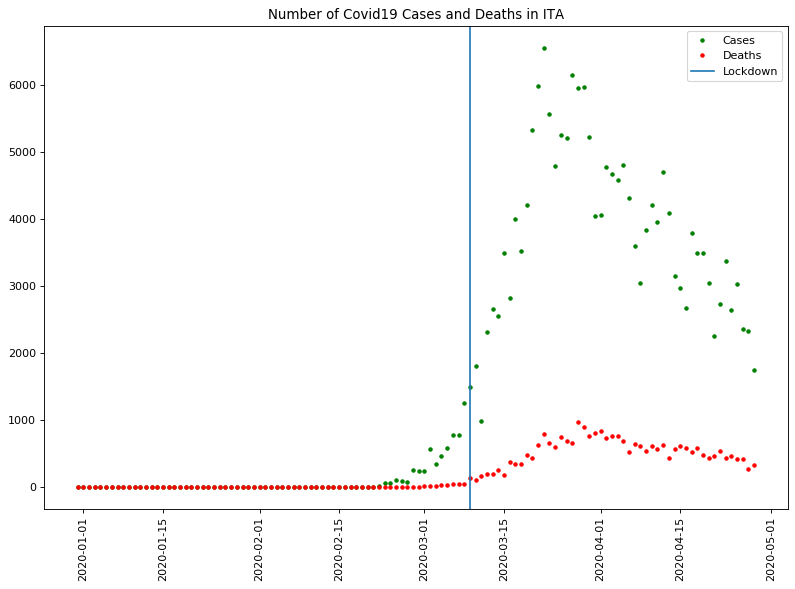

In [10]:
#Reviewing Italy cases and deaths (date of lockdown added manually as this data isn't widely avaliable)
plot_cases(merged_data, 'ITA')
plt.axvline(dt.datetime(2020, 3, 9))
plt.legend(['Cases', 'Deaths','Lockdown']);

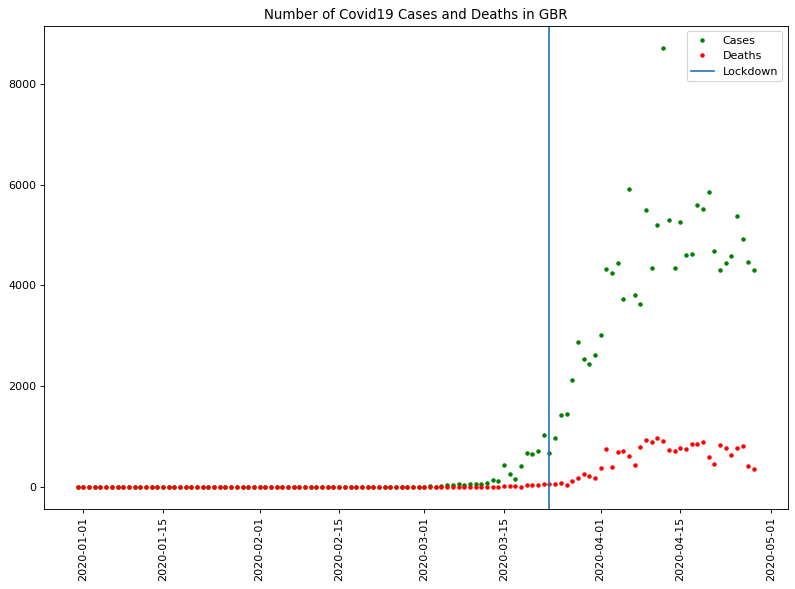

In [11]:
#Reviewing UK cases and deaths (date of lockdown added manually as this data isn't widely avaliable)
plot_cases(merged_data, 'GBR')
plt.axvline(dt.datetime(2020, 3, 23))
plt.legend(['Cases', 'Deaths','Lockdown']);

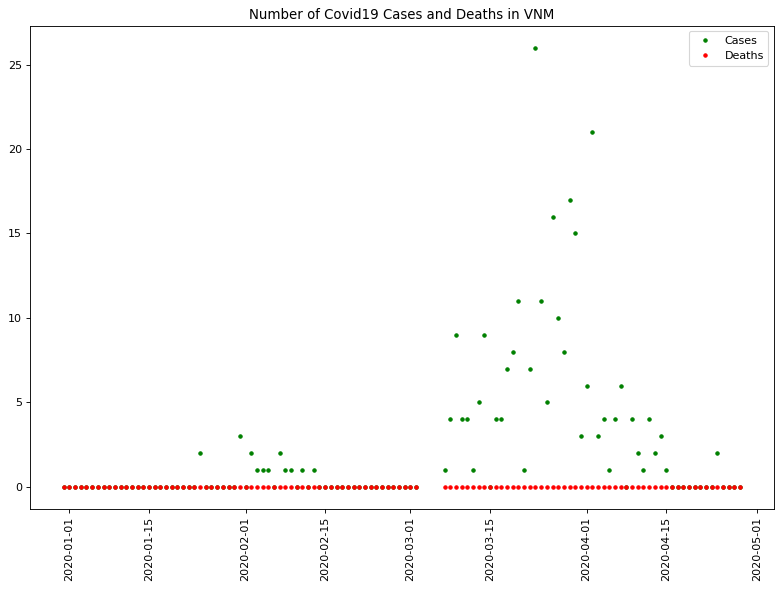

In [12]:
#Looking at Vietnam
#They had a very early lockdown and have not had a single death 
#there seem to be a few reasons why vietnam has done so well combating this
#1.thorough temp screening and checking, intensive testing across the country, strong lockdowns, clear comms
plot_cases(merged_data, 'VNM')

In [13]:
#Aggregating data at a country level to get the stats to compare
agg_data = pd.DataFrame(merged_data.groupby(['country_code'],sort=True)['country_code','country_name','popData2018','tourism','gdp','pop_65','pop_dens','beds'].max())
agg_data.head()

,country_code,country_name,popData2018,tourism,gdp,pop_65,pop_dens,beds
country_code,,,,,,,,
ABW,ABW,Aruba,105845.0,1082000.0,25630.266490,14343.0,588.027778,NaN
AFG,AFG,Afghanistan,37172386.0,NaN,520.896603,960879.0,56.937760,0.5
AGO,AGO,Angola,30809762.0,218000.0,3432.385736,682859.0,24.713052,NaN
ALB,ALB,Albania,2866376.0,5340000.0,5268.848504,393976.0,104.612263,2.9
AND,AND,Andorra,77006.0,3042000.0,42029.762740,NaN,163.842553,NaN


In [14]:
#Creating total number of cases and total number of deaths for each country
sum_cases = pd.DataFrame(merged_data.groupby(['country_code'])['cases'].sum())
sum_deaths = pd.DataFrame(merged_data.groupby(['country_code'])['deaths'].sum())

In [15]:
#Joining aggregated data to sum of cases and deaths
#This does the join on the index which here is country code
agg_data2 = agg_data.merge(sum_cases, left_index = True, right_index = True, how='left')
agg_data2 = agg_data2.merge(sum_deaths, left_index = True, right_index = True, how='left')

In [16]:
#Rename the column names to be sum of cases and deaths
agg_data2.rename(columns={'cases': 'sum_cases','deaths': 'sum_deaths'},inplace = True)
#Add a column of the death rates
agg_data2['death_rate'] = agg_data2['sum_deaths']/agg_data2['sum_cases']
#Add a column for percentage of population over 65
agg_data2['perc_65_plus'] = agg_data2['pop_65']/agg_data2['popData2018']

In [17]:
#Reorder the columns for easier comparison in heat map
cols = ['country_code', 'country_name', 'popData2018', 'tourism', 'gdp',
       'pop_65','perc_65_plus', 'pop_dens','beds', 'death_rate', 'sum_cases', 'sum_deaths' ]

agg_data2 = agg_data2[cols]

In [18]:
agg_data2.describe()

,popData2018,tourism,gdp,pop_65,perc_65_plus,pop_dens,beds,death_rate,sum_cases,sum_deaths
count,2.010000e+02,1.780000e+02,187.000000,1.790000e+02,179.000000,194.000000,125.000000,202.000000,202.000000,202.000000
mean,3.750281e+07,7.651614e+06,18381.888688,3.717484e+06,0.090603,333.482021,3.420800,0.040347,14762.198020,1040.524752
std,1.417059e+08,1.456192e+07,26799.780498,1.391065e+07,0.063787,1514.541442,2.604936,0.041863,75186.420549,5189.825136
min,1.000000e+03,1.400000e+04,271.752044,6.174000e+03,0.010850,0.136497,0.300000,0.000000,1.000000,0.000000
25%,1.308974e+06,4.510000e+05,2351.212688,1.441730e+05,0.033676,37.370577,1.500000,0.008778,76.750000,2.000000
50%,7.061507e+06,1.955000e+06,7246.731656,5.823960e+05,0.070129,91.177915,2.800000,0.029119,604.000000,13.000000
75%,2.626237e+07,8.084250e+06,23373.435025,2.081209e+06,0.147170,218.004208,4.600000,0.056301,4551.250000,96.750000
max,1.392730e+09,8.932200e+07,185741.280000,1.520984e+08,0.275764,19196.000000,13.800000,0.230769,988451.000000,56245.000000


# What are the corralations between the variables and which are most corralated with the number of cases/deaths?

In [20]:
agg_data2.corr()

,popData2018,tourism,gdp,pop_65,perc_65_plus,pop_dens,beds,death_rate,sum_cases,sum_deaths
popData2018,1.000000,0.370666,-0.072435,0.937351,-0.008909,-0.019623,0.004401,0.033988,0.228470,0.185317
tourism,0.370666,1.000000,0.172461,0.515919,0.413695,-0.031035,0.184626,0.257785,0.637251,0.739941
gdp,-0.072435,0.172461,1.000000,0.046628,0.571697,0.478761,0.380610,0.046526,0.170081,0.182556
pop_65,0.937351,0.515919,0.046628,1.000000,0.130430,-0.003335,0.145832,0.083075,0.370131,0.326173
perc_65_plus,-0.008909,0.413695,0.571697,0.130430,1.000000,0.041226,0.671054,0.193676,0.215378,0.276778
pop_dens,-0.019623,-0.031035,0.478761,-0.003335,0.041226,1.000000,0.319339,-0.032645,-0.023344,-0.026377
beds,0.004401,0.184626,0.380610,0.145832,0.671054,0.319339,1.000000,-0.038137,0.029626,0.027409
death_rate,0.033988,0.257785,0.046526,0.083075,0.193676,-0.032645,-0.038137,1.000000,0.142057,0.279108
sum_cases,0.228470,0.637251,0.170081,0.370131,0.215378,-0.023344,0.029626,0.142057,1.000000,0.924530
sum_deaths,0.185317,0.739941,0.182556,0.326173,0.276778,-0.026377,0.027409,0.279108,0.924530,1.000000


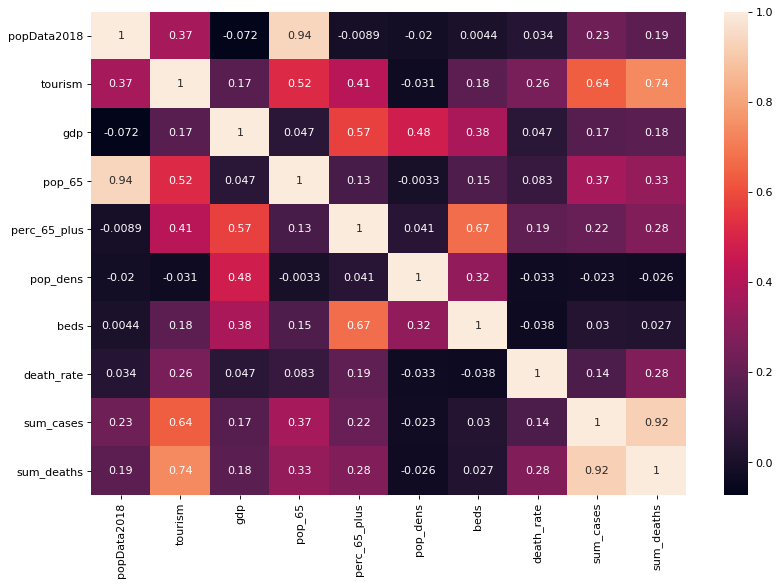

In [21]:
Var_Corr = agg_data2.corr()
# plot the heatmap and annotation on it
plt.figure(figsize=(12,8), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True);

We see that the total cases is most highly corralated with tourism (excluding total deaths) which makes sense as at the beginning of the outbreak, when there not many controls in place and people were still moving freely, the country with the highest number of tourists would have the most exposure to the disease. This is one of reasons why Italy was affected early on in Europe.

The total cases also has a positive corralation with the number of people over 65 in the country. People over 65 are more likely to be badly affected by the virus and hence would be more likely to get tested, pushing the number of cases up. Italy has an aging population and has the 2nd highest percentage of 65+ after Japan in my data. This is another reason why Italy has been badly affected.

There are likely a number of other underlying factors that will have an impact on the number of Covid cases/deaths that are hard to capture. For example, the usage of face masks, the strictness of the lockdown, how well socially distancing is followed etc. Unfortunatly these are too difficult to track at this time to be included in the analysis.

If we look at the plot of tourism by total cases we see the positive corraltion

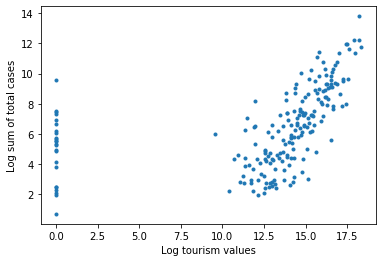

In [22]:
#There are only 24 null values so we will fill them with 0
x = agg_data2['tourism'].fillna(0)
y = agg_data2['sum_cases']
#We are logging the data as without it the data is skewed as some countries cases have grown exponentially (e.g. USA with 780k cases)
plt.plot(np.log(x +1),np.log(y+1),'.')
plt.xlabel("Log tourism values")
plt.ylabel("Log sum of total cases");
#plt.boxplot(y)

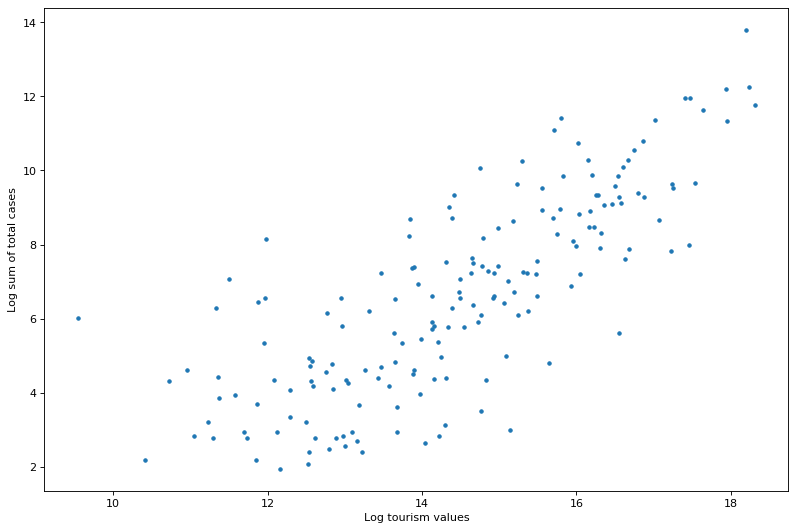

In [23]:
#Might be better to drop the null values to make the plot more appropriate
plt.figure(figsize=(12,8), dpi=80, facecolor='w', edgecolor='k')
agg_data3 = agg_data2.dropna(subset=['tourism'])
x = agg_data3['tourism']
y = agg_data3['sum_cases']
plt.plot(np.log(x +1),np.log(y+1),'.')
plt.xlabel("Log tourism values")
plt.ylabel("Log sum of total cases");
#plt.boxplot(y)

Removing null values, and logging both variables we see a strong positive corralation between tourism numbers and the total cases a coutnry has.
This is expected as the most visitors a country has the most likely they will be to aide the spread of the virus

# Which top 5 countries have the most infections?

In [24]:
#Sort values by most number of total cases
top5_cases = agg_data2.sort_values('sum_cases',ascending=False).head()
top5_cases

,country_code,country_name,popData2018,tourism,gdp,pop_65,perc_65_plus,pop_dens,beds,death_rate,sum_cases,sum_deaths
country_code,,,,,,,,,,,,
USA,USA,United States,327167434.0,79745920.0,62794.58565,51641630.0,0.157845,35.766089,2.9,0.056902,988451,56245
ESP,ESP,Spain,46723749.0,82773000.0,30370.89233,9068471.0,0.194087,93.529058,3.0,0.110711,209465,23190
ITA,ITA,Italy,60431283.0,61567200.0,34483.20400,13746965.0,0.227481,205.450748,3.4,0.135281,199414,26977
GBR,GBR,United Kingdom,66488991.0,36316000.0,42943.90227,12225956.0,0.183879,274.827392,2.8,0.134217,157149,21092
DEU,DEU,Germany,82927922.0,38881000.0,47603.02763,17793207.0,0.214562,237.370970,8.3,0.037822,156337,5913


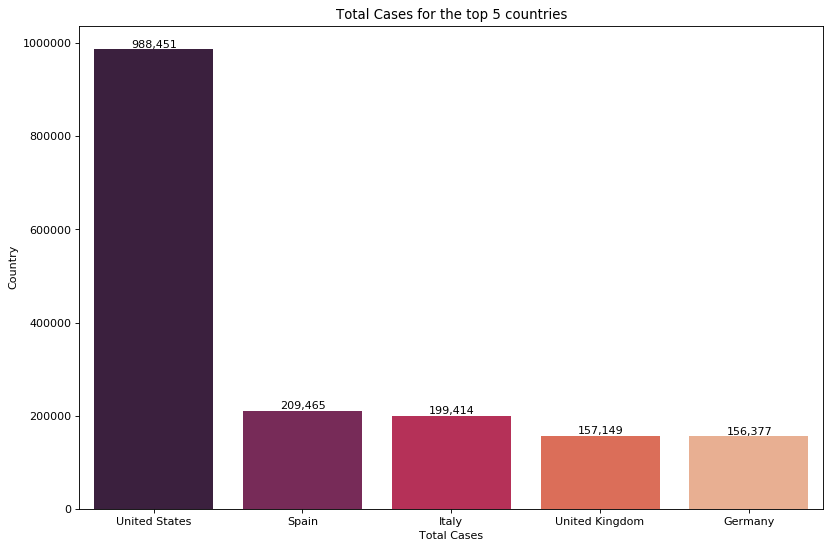

In [60]:
#plotting top 5 countries and their total cases
plt.figure(figsize=(12,8), dpi=80, facecolor='w', edgecolor='k')
sns.barplot(top5_cases['country_name'], top5_cases['sum_cases'],palette="rocket")
plt.title('Total Cases for the top 5 countries')
plt.xlabel('Total Cases')
plt.ylabel('Country')

# Add labels to the plot
# Can you suggest an easier way to do this?
plt.text(-0.15,990000,'988,451')
plt.text(0.85,214000,'209,465')
plt.text(1.85,203000,'199,414')
plt.text(2.85,160000,'157,149')
plt.text(3.85,158000,'156,377');

The USA, Spain, Italy, Germany and the UK currently have the highest number of total cases, with the US massively leading the way. The USA have been wdiely critised for their lockdown approach, with protests going on against the lockdown.
They have the lowest population density, percentage over 65 and the highest GDP out of all these countries, however their approach to the virus has not been as vigilant.

# Which countries have the top 5 deaths?

In [27]:
top5_deaths = agg_data2.sort_values('sum_deaths',ascending=False).head()
top5_deaths

,country_code,country_name,popData2018,tourism,gdp,pop_65,perc_65_plus,pop_dens,beds,death_rate,sum_cases,sum_deaths
country_code,,,,,,,,,,,,
USA,USA,United States,327167434.0,79745920.0,62794.58565,51641630.0,0.157845,35.766089,2.9,0.056902,988451,56245
ITA,ITA,Italy,60431283.0,61567200.0,34483.20400,13746965.0,0.227481,205.450748,3.4,0.135281,199414,26977
FRA,FRA,France,66987244.0,89322000.0,41463.64402,13418612.0,0.200316,122.338396,6.5,0.181496,128339,23293
ESP,ESP,Spain,46723749.0,82773000.0,30370.89233,9068471.0,0.194087,93.529058,3.0,0.110711,209465,23190
GBR,GBR,United Kingdom,66488991.0,36316000.0,42943.90227,12225956.0,0.183879,274.827392,2.8,0.134217,157149,21092


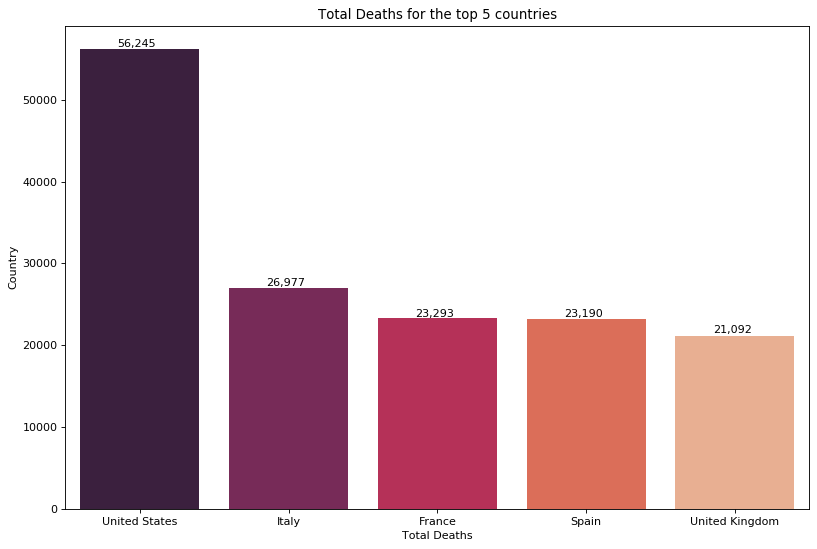

In [62]:
plt.figure(figsize=(12,8), dpi=80, facecolor='w', edgecolor='k')
sns.barplot(top5_deaths['country_name'], top5_deaths['sum_deaths'],palette="rocket")
plt.title('Total Deaths for the top 5 countries')
plt.xlabel('Total Deaths')
plt.ylabel('Country')

# Add labels to the plot
plt.text(-0.15,56500,'56,245')
plt.text(0.85,27200,'26,977')
plt.text(1.85,23500,'23,293')
plt.text(2.85,23500,'23,190')
plt.text(3.85,21500,'21,092');

France is now in the top 5 but USA and Italy keep the lead with the highest number of deaths, with USA again greatly out in front.

# Which 5 countries have the highest death rate

In [29]:
top5_death_rates = agg_data2.sort_values('death_rate',ascending=False).head()
top5_death_rates

,country_code,country_name,popData2018,tourism,gdp,pop_65,perc_65_plus,pop_dens,beds,death_rate,sum_cases,sum_deaths
country_code,,,,,,,,,,,,
NIC,NIC,Nicaragua,6465513.0,1256000.0,2028.894755,339278.0,0.052475,53.727048,0.9,0.230769,13,3
FRA,FRA,France,66987244.0,89322000.0,41463.644020,13418612.0,0.200316,122.338396,6.5,0.181496,128339,23293
SXM,SXM,Sint Maarten (Dutch part),41486.0,178000.0,NaN,NaN,NaN,1193.352941,NaN,0.173333,75,13
VGB,VGB,British Virgin Islands,29802.0,192000.0,NaN,NaN,NaN,198.680000,NaN,0.166667,6,1
BEL,BEL,Belgium,11422068.0,9119000.0,47518.636040,2148165.0,0.188071,377.214927,6.2,0.154368,46687,7207


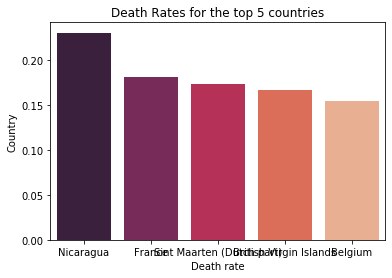

In [30]:
#These countries have the higest death rate because of their small population (excluding France)
# They have a low number of cases and a few deaths which cases the high rates
sns.barplot(top5_death_rates['country_name'], top5_death_rates['death_rate'],palette="rocket")
plt.title('Death Rates for the top 5 countries')
plt.xlabel('Death rate')
plt.ylabel('Country');

The country with the highest death rate at the moment is the Nicaragua, this because they have 12 cases and 3 deaths. Let's look at countries with >10000 cases instead.

In [31]:
data3 = agg_data2[agg_data2['sum_cases']>10000]
top5_death_rates_v2 = data3.sort_values('death_rate',ascending=False).head()
top5_death_rates_v2

,country_code,country_name,popData2018,tourism,gdp,pop_65,perc_65_plus,pop_dens,beds,death_rate,sum_cases,sum_deaths
country_code,,,,,,,,,,,,
FRA,FRA,France,66987244.0,89322000.0,41463.64402,13418612.0,0.200316,122.338396,6.5,0.181496,128339,23293
BEL,BEL,Belgium,11422068.0,9119000.0,47518.63604,2148165.0,0.188071,377.214927,6.2,0.154368,46687,7207
ITA,ITA,Italy,60431283.0,61567200.0,34483.20400,13746965.0,0.227481,205.450748,3.4,0.135281,199414,26977
GBR,GBR,United Kingdom,66488991.0,36316000.0,42943.90227,12225956.0,0.183879,274.827392,2.8,0.134217,157149,21092
SWE,SWE,Sweden,10183175.0,7440000.0,54608.36025,2044763.0,0.200798,25.001043,2.6,0.120152,18926,2274


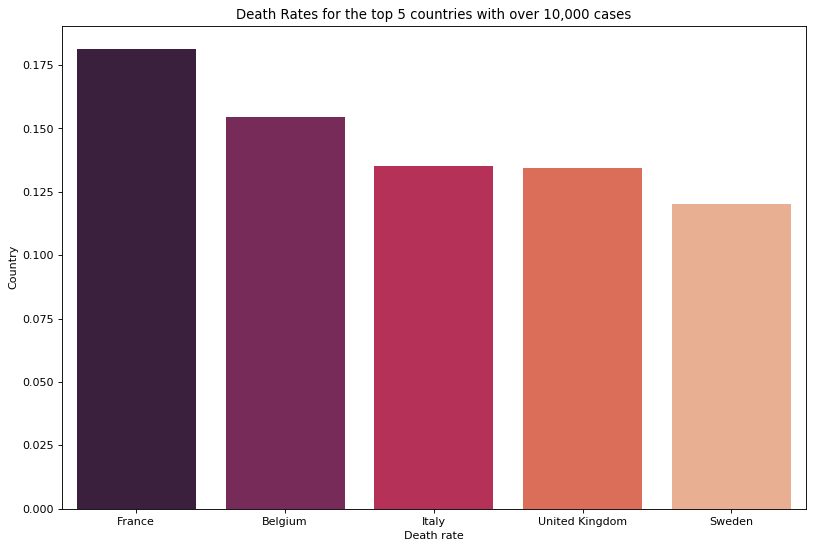

In [32]:
plt.figure(figsize=(12,8), dpi=80, facecolor='w', edgecolor='k')
sns.barplot(top5_death_rates_v2['country_name'], top5_death_rates_v2['death_rate'], palette="rocket")
plt.title('Death Rates for the top 5 countries with over 10,000 cases')
plt.xlabel('Death rate')
plt.ylabel('Country');

We see that France has the highest death rate followed by Belgium, with the US surprsingly last out of our top 5.

In the corralation matrix we saw that death rate had a weak positive corralation with tourism, does slightly hold true excluding Belgium.

However it's more likely that death rate will have a relationship with the level of testing done by each country. From what I have found, the testing data is not very clear, with different countries using different measures leading to inconsistent results so I will not bring it in to my data set. Data here :https://github.com/owid/covid-19-data/blob/master/public/data/testing/covid-testing.xlsx

Taking this data with a pinch of salt, we see that the UK and France as far behind Italy and Spain on testing (although units are inconsistent) with roughly 9 tests per 1000 people performed compared to 28 and 20 per 1000 in Italy and Spain. This could be the reason why the death rate is elevated as there will be high numbers of mild symptom cases going unreported.

Italy also has similar percentages of 65+ people in their population so this could elevate it's death rate.

Note in the data Iceland has by far the highest level of testing with total 133 tests per 1000 people (units unclear).
Having a quick look at the Iceland cases below we see they have seemed to pass over the worst part and have only had a few deaths.  Iceland is obviously also a small island so the virus is easier to contain on that front also.

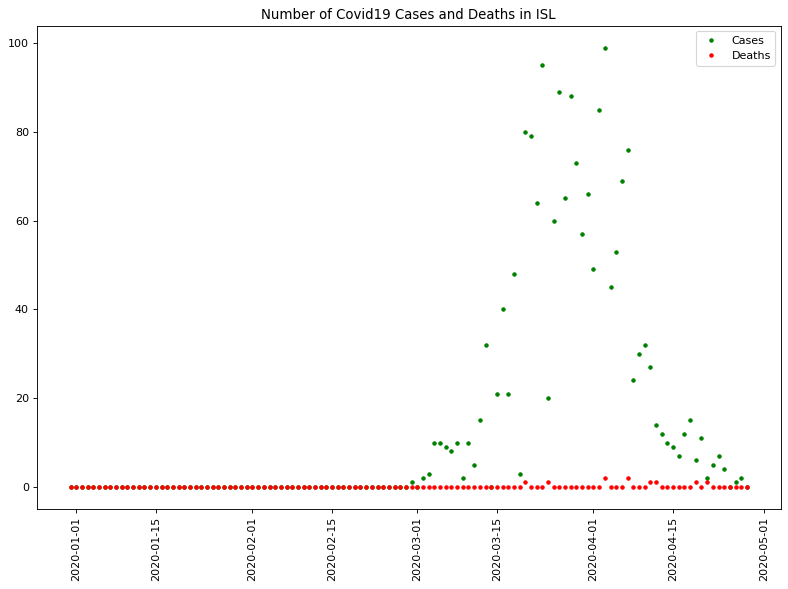

In [33]:
#Having a look at iceland
plot_cases(merged_data, 'ISL')
#High levels of testing has led to low number of cases.

# How are we doing against the virus? Are we flattening the curve?

In [34]:
#Convert the date to datetime
merged_data.head()
merged_data['dateRep'] = pd.to_datetime(merged_data['dateRep'])

In [35]:
subset = merged_data[['dateRep','cases','deaths', 'country_code']]

In [36]:
#Getting cumulative cases and deaths per country over time
cum_data = subset.groupby(['country_code', 'dateRep']).sum().groupby(level=0).cumsum().reset_index()
cum_data.rename(columns = {'cases': 'cum_cases','deaths': 'cum_deaths'}, inplace = True)
cum_data.head()

,country_code,dateRep,cum_cases,cum_deaths
0,ABW,2020-03-13,2,0
1,ABW,2020-03-20,4,0
2,ABW,2020-03-24,12,0
3,ABW,2020-03-25,17,0
4,ABW,2020-03-26,19,0


In [37]:
# Get data where number of deaths > 100
gt_100_dt = cum_data[cum_data['cum_deaths']>100]

In [38]:
#Create an empty data set to append to
final_data = pd.DataFrame(columns=['country_code', 'dateRep', 'cum_cases','cum_deaths','days_since_100'])

#Creating data of countries with >100 deaths and creating a days since 100 deaths field per country
for i in pd.DataFrame(gt_100_dt.groupby(['country_code'])['country_code'])[0]:
    dataset = gt_100_dt[gt_100_dt['country_code'] == i]
    start_date = dataset.iloc[0]['dateRep']
    dataset['days_since_100'] = dataset['dateRep'] - start_date
    final_data = final_data.append(dataset)

In [39]:
final_data.head()

,country_code,dateRep,cum_cases,cum_deaths,days_since_100
435,ARG,2020-04-15,2432,105,0 days
436,ARG,2020-04-16,2432,109,1 days
437,ARG,2020-04-17,2560,115,2 days
438,ARG,2020-04-18,2658,122,3 days
439,ARG,2020-04-19,2828,132,4 days


In [40]:
final_data.dtypes

country_code               object
dateRep            datetime64[ns]
cum_cases                  object
cum_deaths                 object
days_since_100    timedelta64[ns]
dtype: object

In [41]:
#Converting cumulative cases and deaths to floas
final_data['cum_cases'] = final_data['cum_cases'].astype(float)
final_data['cum_deaths'] = final_data['cum_deaths'].astype(float)

In [42]:
#Looking at all countries with > 100 deaths
#This is likely too many to plot
final_data['country_code'].unique()

array(['ARG', 'AUT', 'BEL', 'BGD', 'BRA', 'CAN', 'CHE', 'CHL', 'CHN',
       'COL', 'CZE', 'DEU', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP',
       'FIN', 'FRA', 'GBR', 'GRC', 'HUN', 'IDN', 'IND', 'IRL', 'IRN',
       'ISR', 'ITA', 'JPN', 'KOR', 'MAR', 'MDA', 'MEX', 'NLD', 'NOR',
       'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRT', 'ROU', 'RUS', 'SAU',
       'SRB', 'SWE', 'TUR', 'UKR', 'USA'], dtype=object)

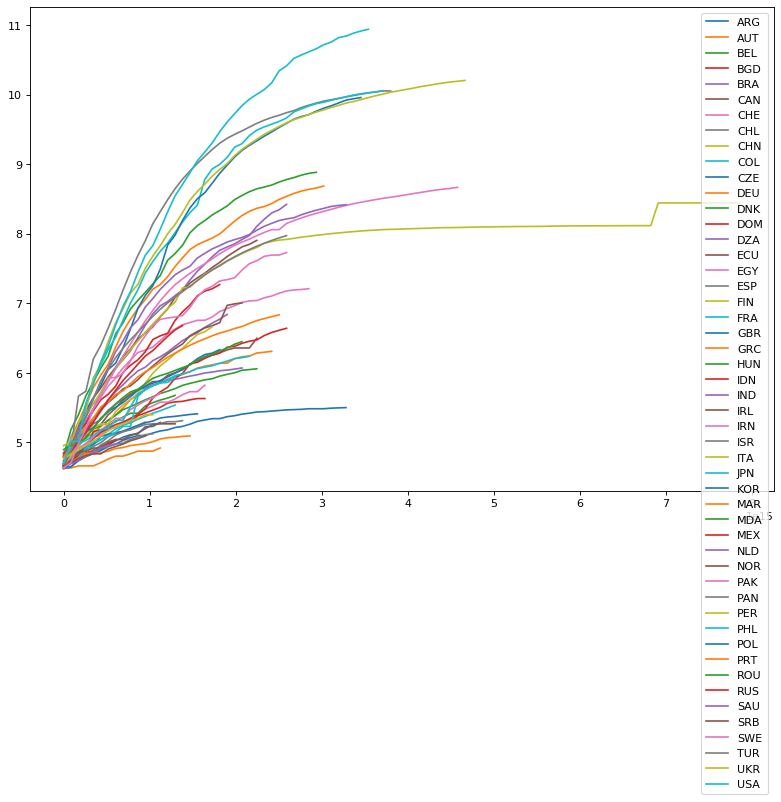

In [43]:
#If we plot all these countries, the graph is not very readable
plt.figure(figsize=(12,8), dpi=80, facecolor='w', edgecolor='k')
for i in pd.DataFrame(gt_100_dt.groupby(['country_code'])['country_code'])[0]:
    x = final_data[final_data['country_code'] == i]['days_since_100']
    y = final_data[final_data['country_code'] == i]['cum_deaths']
    plt.plot(x,np.log(y+1))
    
plt.legend(pd.DataFrame(gt_100_dt.groupby(['country_code'])['country_code'])[0]);    
#Instead we will select a subset that are interesting

In [44]:
#Limit the data at 50 days as this cuts off the long bit that China has as their cases started long before the rest
final_data2 = final_data[final_data['days_since_100'] < '50 days']

In [45]:
#Taking a subset of countries to plot
subset_countries = ['CHN','DEU','ESP','FRA','GBR','IND','ITA','JPN','KOR','USA']

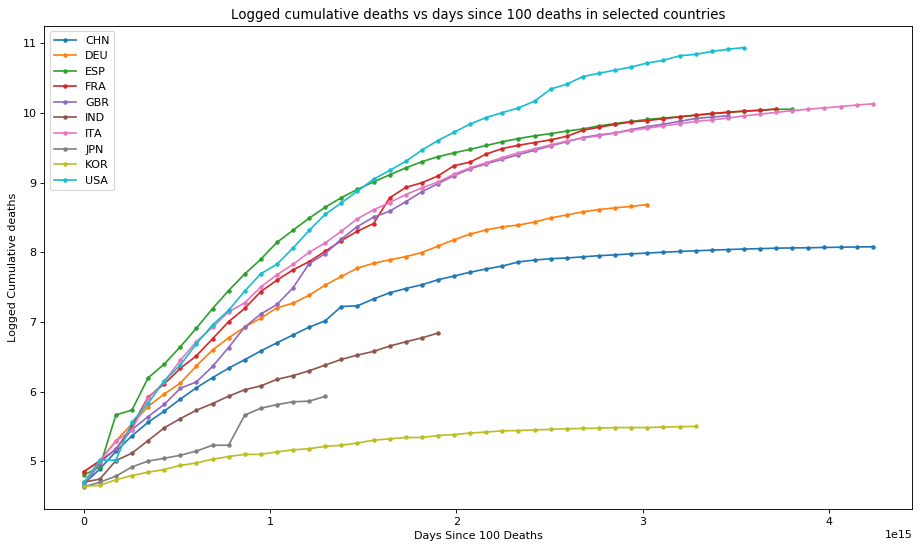

In [46]:
plt.figure(figsize=(14,8), dpi=80, facecolor='w', edgecolor='k')
for i in subset_countries:
    x = final_data2[final_data2['country_code'] == i]['days_since_100']
    y = final_data2[final_data2['country_code'] == i]['cum_deaths']
    plt.plot(x,np.log(y+1), marker='.')   


plt.xlabel("Days Since 100 Deaths")
plt.ylabel("Logged Cumulative deaths")
plt.title("Logged cumulative deaths vs days since 100 deaths in selected countries")
plt.legend(subset_countries);



#This looks much better!

# Can we fit a logistic model to the Italy data? 

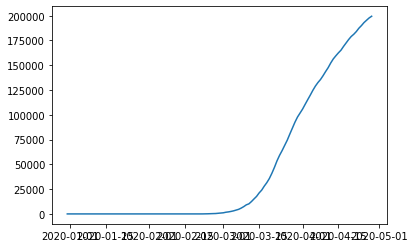

In [47]:
#Just looking at the data and knowing how diseases spread, 
#I'd imagine a logistic function would be best to estimate this
plt.plot(cum_data[cum_data['country_code'] == 'ITA']['dateRep'], cum_data[cum_data['country_code'] == 'ITA']['cum_cases']);

The graph looks like a logistic regression or potentially exponential. However the virus can not spread exponentially as eventually the majority of a country will have it and the spread will slow. Therefor a logistic model would be the best to fit to this data

Using the code created here as a guideline: https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d

In [48]:
#take cumulative data and filter on italy
italy = cum_data[cum_data['country_code'] == 'ITA']

#make the start date beginning of time
start_date = italy.iloc[0]['dateRep']

#get days since start as variable
italy['days_since_start'] = italy['dateRep'] - start_date

#convert days into integers
italy['days_since_start'] = italy['days_since_start'].dt.days

In [49]:
italy.tail()
#We are currently at day 117

,country_code,dateRep,cum_cases,cum_deaths,days_since_start
6631,ITA,2020-04-24,189973,25549,115
6632,ITA,2020-04-25,192994,25969,116
6633,ITA,2020-04-26,195351,26384,117
6634,ITA,2020-04-27,197675,26644,118
6635,ITA,2020-04-28,199414,26977,119


In [50]:
italy['days_since_start']

6516      0
6517      1
6518      2
6519      3
6520      4
       ... 
6631    115
6632    116
6633    117
6634    118
6635    119
Name: days_since_start, Length: 120, dtype: int64

In [51]:
#Define our logistic function
def logistic_f(X, c, k, m):
    y = c / (1 + np.exp(-k*(X-m)))
    return y

#Get our italy data
x = list(italy['days_since_start'])
y = list(italy["cum_cases"])

#Using the optimize function from scipy we fit a logistic function to our data
logistic_model, cov = optimize.curve_fit(logistic_f,x,y,p0=[np.max(italy["cum_cases"]), 1, 1])

In [52]:
#Set parameters
c = logistic_model[0]
k = logistic_model[1]
m = logistic_model[2]

var_c = np.sqrt(cov)[0][0]
var_k = np.sqrt(cov)[1][1]
var_m = np.sqrt(cov)[2][2]

#Print parameters
print ("This means that the expected number of infected people at infection end is {:,.0f} +- {:,.0f}".format(c, var_c))

print ("The model has a growth rate of {:.4f}".format(k))

print("The midpoint of the curve is at {:.0f} days from the beginning of the outbreak (Dec 31st 2019)".format(m))

This means that the expected number of infected people at infection end is 197,406 +- 1,788
The model has a growth rate of 0.1184
The midpoint of the curve is at 91 days from the beginning of the outbreak (Dec 31st 2019)


##### We see that the function is predicting a maximum number of cases of 197,406 +- 1,788

In [53]:
#If we solve for x where y gets to the maximum number of infected(c) then we can get the expected end date of the infections
sol = int(optimize.fsolve(lambda x : logistic_f(x,c,k,m) - int(c),m))
sol

211

#### This would be the 29th of July is expected end of infections in Italy (This is 211 days after the start)

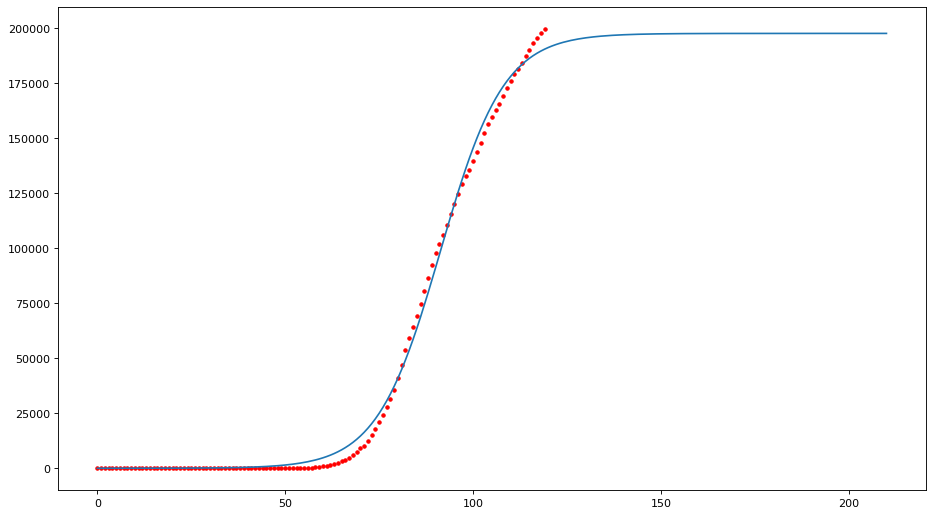

In [54]:
#Plotting the real data
plt.figure(figsize=(14,8), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(x,y, label="Real data",marker = '.',color="red")

#Plotting the predicted logistic curve
pred_x = list(range(max(x),sol))
plt.plot(x+pred_x, [logistic_f(i,c,k,m) for i in x+pred_x]);

We see that the curve fits the data reasonably well with slight differences as the start of the increase and the end of the increase.

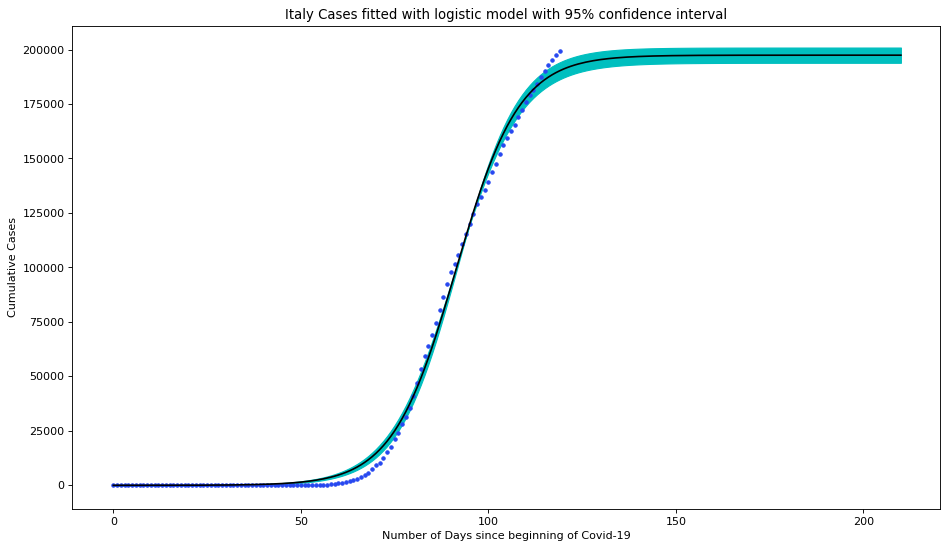

In [55]:
plt.figure(figsize=(14,8), dpi=80, facecolor='w', edgecolor='k')

# Predicted logistic curve
plt.plot(x+pred_x, [logistic_f(i,c,k,m) for i in x+pred_x], label="Logistic model" ,color = 'k')

#plt.plot(x+pred_x, [logistic_f(i,c + var_c,k + var_k ,m + var_m) for i in x+pred_x], color = 'green')
#plt.plot(x+pred_x, [logistic_f(i,c - var_c,k - var_k ,m - var_m) for i in x+pred_x], color = 'pink')

#Getting 95% onfidene interval filled in
plt.fill_between(x+pred_x, [logistic_f(i,c - 1.96*var_c,k - 1.96*var_k ,m - 1.96*var_m) for i in x+pred_x], [logistic_f(i,c + 1.96*var_c,k + 1.96*var_k ,m + 1.96*var_m) for i in x+pred_x], color = 'c')

#Plt real data
plt.scatter(x,y, label="Real data",marker = '.',color='#2748F0')

plt.title("Italy Cases fitted with logistic model with 95% confidence interval")
plt.xlabel("Number of Days since beginning of Covid-19")
plt.ylabel("Cumulative Cases");


This graph shows the fitted logistic model with a 95% confidence interval.

In [56]:
#Look at the mean squared error
y_pred_logistic = [logistic_f(i,c,k,m) for i in x]
mean_squared_error(y,y_pred_logistic)

12423592.933206074

In conclusion, I think the logistic model fits the data ok. I think with more time and data for the curve in Italy to flatten more signficantly we would see better results. Although the data in its current form could appear exponential, I've not fitted this model as it would not be realistic to real life even if the model fitted better.